# Sale Price Prediction of HDB Resale Flat in Singapore

### By Lee Gang

## Table of Contents

1. Data Gathering and Processing
2. 

## 1. Data Gathering and Processing

Import Required Libraries.

In [263]:
import numpy as np
import pandas as pd
import json
import requests
import re
import os
from datetime import datetime as dt
from pandas.io.json import json_normalize
import geocoder
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

### 1.1 Get HDB Flat Resale Data from Data.gov.sg API

We will retrive the HDB Flat resale transaction data from the Data.gov.sg API.

In [264]:
# Get total number of records
url_len = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=1'
max_records = requests.get(url_len).json()['result']['total']

# Extract all records from API
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit={}'.format(max_records)
results = requests.get(url).json()['result']['records']
df_hdb = pd.DataFrame(results)
df_hdb.head()


,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 21,270000,2018-07,63 years 08 months,1983,10 TO 12,1,214
1,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 21,248000,2018-07,63 years 09 months,1983,01 TO 03,2,211
2,JURONG EAST,3 ROOM,New Generation,84,JURONG EAST ST 24,318000,2018-07,63 years 07 months,1983,07 TO 09,3,241
3,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 24,305000,2018-07,66 years 11 months,1986,04 TO 06,4,250
4,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 24,258000,2018-07,65 years 11 months,1985,01 TO 03,5,252


In [265]:
# A quick look at the dimensions of the data extracted
df_hdb.shape

(101994, 12)

Save **HDB Flat Resale Data** to local drive. 

In [266]:
# Save file to local drive, for backup purposes
df_hdb.to_csv("./Data/dat_hdb.csv", index = False)

Read **HDB Flat Resale Data** file from local drive if you want to save time from extracting the data from the API.

In [280]:
# Read file from local drive
df_hdb = pd.read_csv("./Data/dat_hdb.csv")

### 1.2 Clean and Process HDB Flat Resale Data

After looking through the data, we will process it and transform several variables to be usable in our analysis.

In [281]:
# Format column names
df_hdb.rename(columns = {'_id':'id'}, inplace = True)

# Format columns 'floor_area_sqm' and 'resale_price' to float
df_hdb[['floor_area_sqm', 'resale_price']] = df_hdb[['floor_area_sqm', 'resale_price']].astype(float)

# Split column 'month' to 'year' and 'month'
df_hdb['reg_date'] = pd.to_datetime(df_hdb['month'], format = '%Y-%m')
df_hdb['year'] = df_hdb['month'].str[0:4].astype(float)
df_hdb['month'] = df_hdb['month'].str[5:7].astype(float)

# Format column 'year' and 'lease_commencement_date' to integer
df_hdb[['year', 'lease_commence_date']] = df_hdb[['year', 'lease_commence_date']].astype(int)

# Convert 'remaining lease' into float
df_hdb['remaining_years'] = df_hdb['remaining_lease'].str[:2].astype(int)
df_hdb['remaining_months'] = df_hdb['remaining_lease'].str[9:11].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
df_hdb.loc[df_hdb['remaining_months'].isna(), 'remaining_months'] = 0
df_hdb['remaining_lease'] = df_hdb['remaining_years'] + (df_hdb['remaining_months']/12)

# Derive 'price_sqm' 
df_hdb['price_sqm'] = df_hdb['resale_price']/df_hdb['floor_area_sqm']

# Drop extra columns
df_hdb.drop(['remaining_years', 'remaining_months'], axis = 1, inplace = True)

df_hdb.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,id,block,reg_date,year,price_sqm
0,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 21,270000.0,7.0,63.666667,1983,10 TO 12,1,214,2018-07-01,2018,4029.850746
1,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 21,248000.0,7.0,63.750000,1983,01 TO 03,2,211,2018-07-01,2018,3701.492537
2,JURONG EAST,3 ROOM,New Generation,84.0,JURONG EAST ST 24,318000.0,7.0,63.583333,1983,07 TO 09,3,241,2018-07-01,2018,3785.714286
3,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 24,305000.0,7.0,66.916667,1986,04 TO 06,4,250,2018-07-01,2018,4552.238806
4,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 24,258000.0,7.0,65.916667,1985,01 TO 03,5,252,2018-07-01,2018,3850.746269


### 1.3 Map and Process Street Name for Geocoding Purposes

In order to retrieve all nearby venues for each location, we will need to geocode the address of the location. After a few trial and errors with different geocoders, we will use the Nominatim-OSM geocoder and the following transformation of the *'street_name'* variable so that all locations will be able to be succesfully geocoded.

Only *'street_name'* is used. This is due to the large amount of unique full address that will consume excessive resources for the geocoding and Foursquare API queries (less than 100k queries per day limit).

In [282]:
# Format "street_name" column for geocoding purposes
df_hdb['street_name'] = df_hdb['street_name'].str.replace('UPP ', 'UPPER ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace(' CTRL', ' CENTRAL', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('JLN ', 'JALAN ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('BT ', 'BUKIT ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('LOR ', 'LORONG ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace(' NTH', ' NORTH', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('NTH BRIDGE', 'NORTH BRIDGE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('KG', 'KAMPONG', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace(' DR', ' DRIVE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('TG PAGAR', 'TANJONG PAGAR', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("C'WEALTH", 'COMMONWEALTH', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("WOODLANDS DRIVE 75", 'WOODLAND DRIVE 75', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("TAMAN HO SWEE", 'JALAN BUKIT HO SWEE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("YUNG PING RD", '157 CORPORATION DRIVE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("YUNG LOH RD", '157 CORPORATION DRIVE', regex = True)

### 1.4 Extract Coordinates via Nominatim/OSM Geocoding (For Initial Run Only)

The geocoding of the **HDB Flat Resale Data** will take more than 30 minutes. tTe codes below are for the initial run only. The result will be saved in a **Coordinates Dataframe**, which will be used for subsequent runs. Only addresses not in the saved **Coordinates Dataframe** will be identified and geocoded for subsequent runs.

In [268]:
# Create unique list of all street names in HDB Flat Resale Data
df_coord = pd.DataFrame(df_hdb['street_name'].unique())
df_coord.columns = ['street_name']
length = len(df_coord['street_name'])

In [6]:
# Set up loop to geocode each unique address
latitude = np.zeros(length)
longitude = np.zeros(length)
address = df_coord['street_name']

for n in range(0,len(address)):
    geo = geocoder.osm(address[n] + ', SG')
    if geo.x is None:
        latitude[n] = 0
        longitude[n] = 0
    else:
        latitude[n] = geo.y
        longitude[n] = geo.x


In [7]:
# Compile results into Coordinates Dataframe
df_coord['Latitude'] = latitude
df_coord['Longitude'] = longitude
df_coord.loc[df_coord['Latitude'].isna(), 'Latitude'] = 0
df_coord.loc[df_coord['Longitude'].isna(), 'Longitude'] = 0

# Check geocoding results
print('Successfully Geocoded ' + str(df_coord[df_coord["Longitude"]!=0].shape[0]) + ' Rows')
print('Unsuccessfully Geocoded ' + str(df_coord[df_coord["Longitude"]==0].shape[0]) + ' Rows')

Successfully Geocoded 538 Rows
Unsuccessfully Geocoded 1 Rows


Save **Coordinates Dataframe** to Local Drive

In [ ]:
df_coord.to_csv('./Data/dat_coord.csv', index = False)

### 1.5 Extract Coordinates Data & Geocode Missing Coordinates (For Subsequent Runs)

Retrieve previously saved **Coordinates Dataframe** from local drive

In [244]:
df_coord = pd.read_csv('./Data/dat_coord.csv')

Check **Coordinates Data** with **HDB Flat Resale Data** on any missing coordinates for all addresses.

In [11]:
df_coord_new = pd.DataFrame(df_hdb['street_name'].unique())
df_coord_new.columns = ['street_name']
df_coord_new = df_coord_new.merge(df_coord, how = 'left', on = 'street_name')
df_check = df_coord_new[df_coord_new['Latitude']==0]
df_check.head()

,street_name,Latitude,Longitude


Retrieve coordinates for all addresses with missing coordinates.

In [12]:
if (df_check.shape[0]>0):
    length = len(df_coord['street_name'])
    latitude = np.zeros(length)
    longitude = np.zeros(length)
    address = df_coord['street_name']
    
    for n in range(0,len(address)):
        geo = geocoder.osm(address[n] + ', SG')
        if geo.x is None:
            latitude[n] = 0
            longitude[n] = 0
        else:
            latitude[n] = geo.y
            longitude[n] = geo.x
    df_check['Latitude'] = latitude
    df_check['Longitude'] = longitude


Combined additional coordinates data to **Coordinates Dataframe**.

In [13]:
# Combined additional coordinates data to main Coordinates Dataframe
df_coord = df_coord_new.append(df_check)
df_coord.head()

,street_name,Latitude,Longitude
0,JURONG EAST ST 21,1.333969,103.745903
1,JURONG EAST ST 24,1.342401,103.743049
2,JURONG EAST ST 32,1.344607,103.733691
3,PANDAN GDNS,1.319415,103.748373
4,TEBAN GDNS RD,1.320053,103.744970


Save updated **Coordinates Dataframe** to local drive.

In [24]:
df_coord.to_csv('./Data/dat_coord.csv', index = False)

### 1.6 Retrieve Nearby Venues for Each Street Using Foursquare API

Setup API credentials.

In [14]:
d1 = dt.today().strftime("%Y%m%d")
CLIENT_ID = '(Foursquare Client ID): ' 
CLIENT_SECRET = '(Foursquare Secret ID)' 
VERSION = d1 # Foursquare API version

Define **'getNearbyVenues'** function to extract nearby venues from json. We set the default radius to 500m and limit to 100 venues due to computing constraints and Foursquare API limits. 

As Singapore is a tight and highly dense city state, there will be quite a lot of venues within a 500m radius. Venues within 500m will most probably have more weightage in terms of the impact on the resale price of a property, as compared to venues further away. As such, we will only use these parameters for this study.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
             
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['street_name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Retrieve all nearby venues and compile into a **Nearby Venues Dataframe**

In [16]:
df_venues = getNearbyVenues(names = df_coord['street_name'],
                            latitudes = df_coord['Latitude'],
                            longitudes = df_coord['Longitude'])

In [269]:
# A quick look of the number of nearby venues extracted
df_venues.shape

(12771, 7)

Save **Nearby Venues Dataframe** to local drive for easy retrieval.

In [22]:
df_venues.to_csv("./Data/dat_venues.csv", index = False)

Retrieve **Nearby Venues Dataframe** from local drive.

In [270]:
df_venues = pd.read_csv("./Data/dat_venues.csv")

### 1.7 Feature Engineering Using Nearby Venues Data

In [271]:
# A quick view of the nearby venues dataset
df_venues.head()

,street_name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,JURONG EAST ST 21,1.333969,103.745903,Platinum Movie Suites,1.333425,103.744113,Movie Theater
1,JURONG EAST ST 21,1.333969,103.745903,Hai Di Lao 海底捞火锅 (Hai Di Lao),1.334577,103.746118,Hotpot Restaurant
2,JURONG EAST ST 21,1.333969,103.745903,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant
3,JURONG EAST ST 21,1.333969,103.745903,UNIQLO,1.333175,103.743160,Clothing Store
4,JURONG EAST ST 21,1.333969,103.745903,J-Walk,1.333946,103.744433,Trail


### Streamline Venue Categories

Only major venue categories that we believe might affect property prices are grouped. Feel free to include additional venue categories on your own (and let me know if there is any interesting findings).

In [272]:
# Bus Stops
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Bus Station', 'Bus Stop', 'Bus Line'], 
    'Bus Stop', regex = True)

# Train Stations
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Train Station', 'Metro Station', 'Light Rail Station'], 
    'Train Station', regex = True)

# Supermarkets
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Supermarket', 'Department Store', 'Convenience Store', 'Grocery Store'], 
    'Supermarket', regex = True)

# Parks
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Park', 'Lake', 'Garden', 'Other Great Outdoors'], 
    'Park', regex = True)

# Shopping Malls
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Shopping Mall', 'Shopping Plaza'], 
    'Shopping Mall', regex = True)

# Gyms
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Gym', 'Gym / Fitness Center', 'Climbing Gym', 'College Gym'], 
    'Gym', regex = True)

# Theaters
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Multiplex', 'Theater', 'Movie Theater', 'Indie Theater', 'College Theater'], 
    'Theater', regex = True)

# Museums
df_venues.loc[df_venues['Venue Category'].str.contains('Museum', case=False), 'Venue Category'] = 'Museum'

# Restaurants
df_venues.loc[df_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'

### Filter Nearby Venues Dataframe with only Selected Venue Categories

In [273]:
# Create list of selected Venue Categories
venue_list = ['Bus Stop', 'Train Station', 'Supermarket', 'Park', 'Shopping Mall',
              'Gym', 'Theater', 'Restaurant', 'High School', 'General College & University',
              'Museum', 'Food Court']

# Filter venue dataframe with venue list
df_vcat = df_venues.loc[df_venues['Venue Category'].isin(venue_list),]

In [274]:
# Format Venue Categories Dataframe to tidy format
df_vcat = pd.DataFrame(df_vcat.groupby(['street_name', 'Venue Category'])['Venue'].count())
df_vcat = df_vcat.reset_index()
df_vcat = df_vcat.pivot(index='street_name',columns='Venue Category',values='Venue')
df_vcat = df_vcat.reset_index()
df_vcat.fillna(0, inplace = True)
df_vcat.head()

Venue Category,street_name,Bus Stop,Food Court,General College & University,Gym,High School,Museum,Park,Restaurant,Shopping Mall,Supermarket,Theater,Train Station
0,157 CORPORATION DRIVE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ADMIRALTY DRIVE,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0
2,ADMIRALTY LINK,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AH HOOD RD,0.0,4.0,0.0,0.0,0.0,0.0,1.0,12.0,1.0,1.0,0.0,0.0
4,ALJUNIED CRES,0.0,2.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,2.0,0.0,1.0


In [275]:
# Check for missing values
df_vcat.isnull().sum()

Venue Category
street_name                     0
Bus Stop                        0
Food Court                      0
General College & University    0
Gym                             0
High School                     0
Museum                          0
Park                            0
Restaurant                      0
Shopping Mall                   0
Supermarket                     0
Theater                         0
Train Station                   0
dtype: int64

### Merge Venue Category And Coordinates Dataframe with HDB Dataframe

Perform One-Hot Encoding for columns "town", "flat_type", 'flat_model" and "storey_range" and merge with **HDB Flat Resale Data** to form a **Main Dataframe** (for interpretation/ reference purposes) and a **Final Dataframe** (to be used in model building).

In [283]:
df_main = df_hdb.merge(df_vcat, how = 'left', on = 'street_name')
df_main = df_main.fillna(0)
df_onehot = pd.get_dummies(df_main[['town', 'flat_type', 'flat_model', 'storey_range']])
df_final = df_main.join(df_onehot)
df_final.drop(['town', 'flat_type','flat_model','storey_range', 'street_name', 
               'resale_price','id','block','lease_commence_date','reg_date'], 
              axis = 1, inplace = True)
df_final.head()

,floor_area_sqm,month,remaining_lease,year,price_sqm,Bus Stop,Food Court,General College & University,Gym,High School,...,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51
0,67.0,7.0,63.666667,2018,4029.850746,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,67.0,7.0,63.750000,2018,3701.492537,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,84.0,7.0,63.583333,2018,3785.714286,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,67.0,7.0,66.916667,2018,4552.238806,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,67.0,7.0,65.916667,2018,3850.746269,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## 2. Exploratory Data Analysis

### 2.1 Explore dataset and identify high colinearity variables

As most models are not robust to high co-linearity between variables, we will identify variables with high co-linearity by plotting a correlation plot.

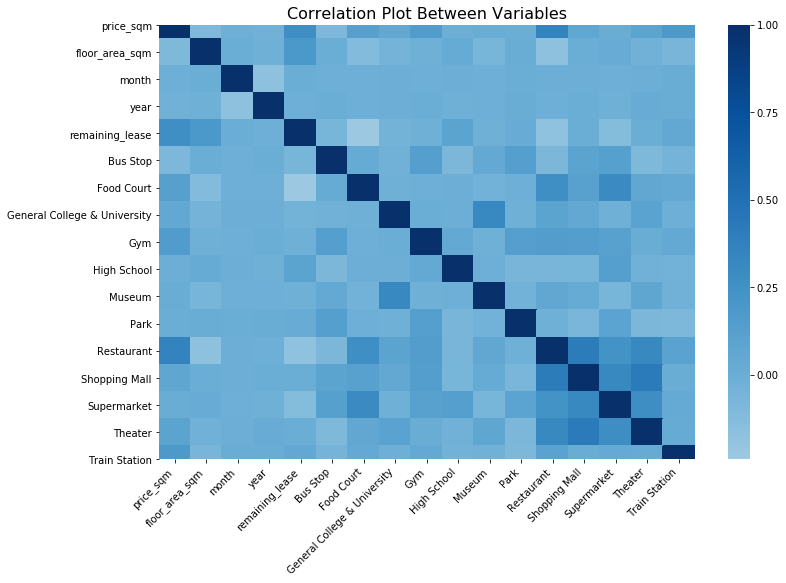

In [284]:
# Correlation between property detail variables

df_corr1 = df_final[['price_sqm',  'floor_area_sqm', 'month', 'year', 'remaining_lease', 'Bus Stop',
                     'Food Court', 'General College & University', 'Gym', 'High School',
                     'Museum', 'Park', 'Restaurant', 'Shopping Mall', 'Supermarket',
                     'Theater', 'Train Station']].copy()

corr1 = df_corr1.corr()

plt.figure(figsize=(12,8))
ax = sns.heatmap(corr1,
                 center = 0,
                 cmap='Blues')


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

ax.set_title("Correlation Plot Between Variables", size =16);

In [285]:
# Save figure in local drive
fig = ax.get_figure()
fig.savefig("./Images/Correlation_Plot.png")

We can see that there are some degrees of co-linearity between the number of Restaurants, Shopping Mall, Supermarket and Theaters. However, there are no strong co-linearity between the variables. As such, we will not remove any variables from the dataset.

### 2.2 Check on Zero and Near Zero Variance Variables

Firstly, let's list out all variables with zero variance.

In [286]:
from sklearn.feature_selection import VarianceThreshold

var0_filter = VarianceThreshold(threshold=0.0)
var0_filter.fit(df_final, y= df_final['price_sqm'])

pd.DataFrame(df_final.columns[var0_filter.get_support()==False])

,0


The dataset does not contain any zero variance variables. Now let's see how many variables have less than 5% variance.

In [287]:
var5_filter = VarianceThreshold(threshold=0.05)
var5_filter.fit(df_final, y= df_final['price_sqm'])

pd.DataFrame(df_final.columns[var5_filter.get_support()==False])

,0
0,General College & University
1,High School
2,Museum
3,town_ANG MO KIO
4,town_BEDOK
5,town_BISHAN
6,town_BUKIT BATOK
7,town_BUKIT MERAH
8,town_BUKIT PANJANG
9,town_BUKIT TIMAH


There are a total of 54 variables with less than 5% variance. We can see that most of the variables are due to the one-hot encoding of variables *'town'*, *'flat_model'*, *'flat_type'* and *'storey_range'*. These are still variables that might have important information for the model. As such we will not exclude these columns.

As for *'General College & University'*, *'High School'* and *'Musuem'* columns, we will remove them from the dataset as these venues seem to be rare around residences and might introduce more noise than information.

In [288]:
# Drop 'General College & University', 'High School', and 'Museum' columns from dataset
df_final = df_final.drop(['General College & University', 'High School', 'Museum'], axis = 1)
df_final.shape

(101994, 84)

Save **Final Dataframe** to local drive.

In [289]:
df_final.to_csv("./Data/dat_final.csv", index = False)

## 3. Model Building and Evaluation

### 3.1 Preprocess Data for Model Building

Split Dataset into Features Set and Target Set ( X, y). The **price_sqm** will be our dependent variable.

In [290]:
y = df_final['price_sqm']
X = df_final.drop(['price_sqm'], axis = 1)

Split Dataset into training and testing sets

In [291]:
# Split datasets into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 2020)

Standardize datasets using StandardScaler

In [292]:
# Standardize Dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_trains = scaler.transform(X_train)
X_tests = scaler.transform(X_test)

### 3.2 Model Building: Lasso Regression

As we have a sparse dataset with 83 independent variables, we will use lasso regression instead of simple linear regression. Lasso regression introduces a regularisation term that reduces the magnitude of the coefficients (feature selection).

**Perform Grid Search 5-Fold Cross-Validation to Select Best *alpha***

We will use grid serach to fit the **Lasso Regression** model to different *alpha* (L1 regularisation) values, and select the best *alpha* value based on the cross-validated model's *mean square error*.

In [175]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from scipy import stats
import math
import statistics

# Initialize GridSearch Cross-Validation for lasso across different alpha (l1 reg) values
lasso = Lasso()
param = {'alpha':[0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]}

lasso_cv = GridSearchCV(lasso,
                       param,
                       scoring = 'neg_mean_squared_error',
                       cv = 5,
                       verbose = 0)

In [44]:
# Run GridSearchCV using Training Dataset to find best alpha value
lasso_cv.fit(X_trains,y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8174702295.288083, tolerance: 8783354.30542167
  positive)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5,
                                   2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [59]:
best_alpha = pd.Series(lasso_cv.best_params_)[0]

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-268295.44825499854
{'alpha': 0.01}


**Build Final Lasso Regression Model Using Best *alpha* Value**

In [293]:
# Fit final lasso model with best alpha value
lasso = Lasso(alpha = best_alpha, 
              random_state = 2020)
lasso = lasso.fit(X_trains, y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100901952.16036606, tolerance: 11015115.179274742
  positive)


### 3.3 Model Diagnosis: Lasso Regression

We will now use the testing data to evaluate our model.

In [294]:
yhat = lasso.predict(X_tests)
MAE_lasso = round(mean_absolute_error(y_test, yhat),2)
RMSE_lasso = round(math.sqrt(mean_squared_error(y_test, yhat)),2)
R2_lasso = round(r2_score(y_test, yhat),2)

print('-------------- Lasso Regression Model ------------')
print('MAE: ' + str(mean_absolute_error(y_test, yhat)))
print('RMSE: '+ str(math.sqrt(mean_squared_error(y_test, yhat))))
print('R^2 Score: ' + str(r2_score(y_test, yhat)))

-------------- Lasso Regression Model ------------
MAE: 406.28898811955264
RMSE: 527.0607772319033
R^2 Score: 0.8142585093070762


In [295]:
# Create Results Dataframe and store model performance metrics in dataframe
df_results = pd.DataFrame()
df_results['Metrics'] = ['MAE', 'RMSE', 'R2 Score']
df_results['Lasso Regression'] = [MAE_lasso, RMSE_lasso, R2_lasso]
df_results

,Metrics,Lasso Regression
0,MAE,406.29
1,RMSE,527.06
2,R2 Score,0.81


Let's visualize the residuals of the **Lasso Regression** model.

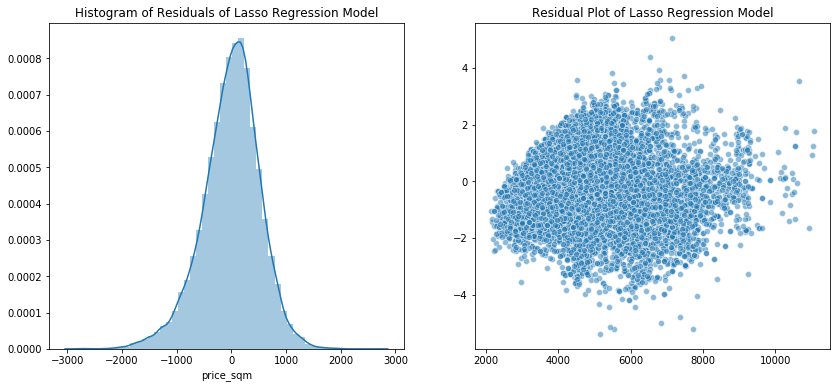

In [298]:
# Calculate residuals
lasso_res = yhat - y_test
lasso_res_st = stats.zscore(lasso_res)

# Setup subplots and plot graphs
fig1, axes = plt.subplots(1,2, figsize = (14,6))
sns.distplot(lasso_res, ax = axes[0])
sns.scatterplot(y = lasso_res_st, x = yhat, alpha = 0.5, ax = axes[1])
axes[0].set_title("Histogram of Residuals of Lasso Regression Model", size =12)
axes[1].set_title("Residual Plot of Lasso Regression Model", size =12);

Based on the residuals histogram, the residuals have a normal distribution. As for the residual plot, the residuals seem to be distributed randomly over the horizontal axis. Overall, the residuals distribution does not suggest any major violation of the assumptions of the **Lasso Regression** model.

In [299]:
# Save figure in local drive
fig1.savefig("./Images/Lasso_Residuals.png")

### 3.4 Model Building: Extreme Gradient Boosted Trees (XGBoost)

**XGBoost** is used as it is one of the top performing machine learning algorithms used in competitions. It is more robust when dealing with high dimensions, as well as it has faster performance as compared to other complex and ensemble algorithms.

In [423]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Convert datasets to XGBDMatrix
dtrain = xgb.DMatrix(X_trains, label = y_train)
dtest = xgb.DMatrix(X_tests)


**Build Default Baseline Model**

Define Model Parameters and perform cross-validation to get best 'num_boost_rounds'.

In [41]:
# Define model parameters
xgb_params = {'obj':'reg:squarederror',
              'eval_metric':'rmse',
              'max_depth':6, 
              'eta':0.5,
              'min_child_weight':1,
              'subsample':1,
              'colsample_bytree':1}

# Find model parameters 'num_boost_round' using cv
cv_res = xgb.cv(xgb_params, 
                dtrain, 
                num_boost_round=500, 
                nfold=5, 
                seed=2020, 
                stratified=False,
                early_stopping_rounds=25, 
                verbose_eval=10, 
                show_stdv=True)

# Get best num_boost_round
nrounds = cv_res[cv_res['test-rmse-mean'] == cv_res['test-rmse-mean'].min()].index[0]
cv_res[cv_res['test-rmse-mean'] == cv_res['test-rmse-mean'].min()]

[0]	train-rmse:2407.9+1.14391	test-rmse:2408.32+6.59549
[10]	train-rmse:414.106+7.75005	test-rmse:421.967+7.37412
[20]	train-rmse:341.551+1.71697	test-rmse:353.132+2.08011
[30]	train-rmse:310.225+2.07543	test-rmse:325.373+3.82845
[40]	train-rmse:290.43+1.4601	test-rmse:308.857+3.62427
[50]	train-rmse:278.165+1.2267	test-rmse:299.135+2.97099
[60]	train-rmse:267.468+0.925297	test-rmse:290.789+2.79074
[70]	train-rmse:258.724+0.942736	test-rmse:284.49+2.31703
[80]	train-rmse:251.378+1.13481	test-rmse:279.691+2.0723
[90]	train-rmse:245.281+0.919015	test-rmse:276.016+2.535
[100]	train-rmse:239.513+0.63391	test-rmse:272.815+2.57721
[110]	train-rmse:234.97+0.552045	test-rmse:270.185+2.09791
[120]	train-rmse:230.475+0.850855	test-rmse:267.731+1.92338
[130]	train-rmse:226.508+1.07034	test-rmse:265.762+1.91121
[140]	train-rmse:222.391+1.0819	test-rmse:263.587+1.92365
[150]	train-rmse:219.274+1.00303	test-rmse:262.389+2.123
[160]	train-rmse:216.086+1.09584	test-rmse:260.867+2.45202
[170]	train-rms

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
499,152.271869,1.374683,242.551694,2.179905


Build Baseline XGBoost Model using model parameters and best 'num_boost_rounds' from cv.

In [42]:
# Build xgb model

xgb_def = xgb.train(params = xgb_params,
                   num_boost_round = nrounds,
                   dtrain = dtrain)

Evaluate Model Performance Using Testing Dataset

In [424]:
# Evaluate Default Model Performance Using test set

yhat = xgb_def.predict(dtest)
print('-------------- XGB Model: Baseline Parameters ------------')
print('MAE: ' + str(mean_absolute_error(y_test, yhat)))
print('RMSE: '+ str(math.sqrt(mean_squared_error(y_test, yhat))))
print('R^2 Score: ' + str(r2_score(y_test, yhat)))


NameError: name 'xgb_def' is not defined

We can see that the baseline **XGBoost** model already outperforms **Lasso Regression** significantly.

**Perform Randomized Grid Search for Hyper Parameter Tuning**

To optimize the computing resources used, we will use randomized grid search for tuning the hyper-parameters of the model.

In [44]:
# Define and setup Randomized Grid Search for Hyperparaneter Tuning

grid_params = {'max_depth': [8, 10, 12, 13],
               'min_child_weight': [1, 2, 3, 4],
               'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7], #eta
               'gamma': [0.5, 1, 1.5, 2],
               'subsample': [0.8, 0.9, 1.0],
               'colsample_bytree': [0.8, 0.9, 1.0]
              }

xgb_tune = xgb.XGBRegressor(objective = 'reg:squarederror',
                            eval_metric= 'rmse',
                            n_estimators = 200,
                            seed = 2020)

rkf = RepeatedKFold(n_splits=5, random_state = 2020)

random_search = RandomizedSearchCV(xgb_tune, 
                                   param_distributions=grid_params, 
                                   n_iter=10, 
                                   scoring='neg_root_mean_squared_error', 
                                   n_jobs=4, 
                                   cv=rkf.split(X_trains,y_train), 
                                   verbose=3, 
                                   random_state=2020)

In [45]:
# Run randomized Grid Search
random_search.fit(X_trains, y_train)

# Show best parameters from randomized grid search
best_params = random_search.best_params_
best_params

Fitting 50 folds for each of 10 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 10.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 59.7min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 177.6min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 303.2min finished
C:\Users\admin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 13,
 'learning_rate': 0.3,
 'gamma': 2,
 'colsample_bytree': 1.0}

Save tuning results to local drive just in case. We do not want to spend a few hours again.

In [46]:
# Get full Grid Search Results and save results to csv
pd.DataFrame(random_search.cv_results_).to_csv("./Data/xgb_cv_results.csv", index = False)
random_search.cv_results_

{'mean_fit_time': array([106.07225914,  96.08375383, 202.41872158, 200.70092591,
        168.45867692, 117.10977341, 133.11216463, 152.20385117,
        168.78275886,  97.06441286]),
 'std_fit_time': array([1.11830978, 0.73273093, 1.26767458, 1.25609669, 0.98319251,
        0.52050316, 3.83804184, 2.85648627, 2.79414294, 1.47089036]),
 'mean_score_time': array([0.52263805, 0.51095347, 1.57844553, 1.47662493, 1.48932211,
        0.49109525, 0.95577505, 1.30863798, 1.4556285 , 0.54487116]),
 'std_score_time': array([0.01691211, 0.01405513, 0.06113785, 0.07616722, 0.06549898,
        0.01566941, 0.07955839, 0.05550543, 0.07219437, 0.10881179]),
 'param_subsample': masked_array(data=[0.8, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 1, 2, 2, 3, 1, 3, 3, 3],
              mask=[

**Perform Cross-Validation to Find Best Number of Trees**

Now fit in the tuned hyper-parameters into a 5-fold cross-validation model to get the best 'num_boost_rounds'.

In [49]:
# Modify best params dict to fit to native xgb format
best_params['eta'] = best_params['learning_rate']
del best_params['learning_rate']

# Fit xgb model with best parameters to find best 'num_boost_round' using cv
cv_tuned = xgb.cv(best_params, 
                  dtrain, 
                  num_boost_round=500, 
                  nfold=5, 
                  seed=2020, 
                  stratified=False,
                  early_stopping_rounds=10, 
                  verbose_eval=0, 
                  show_stdv=True)


[0]	train-rmse:3280.56+1.44227	test-rmse:3280.97+6.73718
[10]	train-rmse:290.423+4.46502	test-rmse:323.892+1.54562
[20]	train-rmse:203.836+4.38013	test-rmse:262.806+2.66416
[30]	train-rmse:175.761+3.45236	test-rmse:248.765+2.10898
[40]	train-rmse:156.839+4.09864	test-rmse:241.765+2.49276
[50]	train-rmse:140.173+3.99963	test-rmse:236.955+2.3286
[60]	train-rmse:128.227+2.8083	test-rmse:234.188+2.19593
[70]	train-rmse:116.868+2.56887	test-rmse:231.477+2.49898
[80]	train-rmse:106.13+2.16773	test-rmse:229.501+2.31015
[90]	train-rmse:97.7946+1.57815	test-rmse:228.151+2.35716
[100]	train-rmse:89.742+1.77458	test-rmse:227.105+2.44442
[110]	train-rmse:82.7636+1.58486	test-rmse:226.3+2.51419
[120]	train-rmse:77.1238+1.94923	test-rmse:225.691+2.44239
[130]	train-rmse:70.8248+1.6308	test-rmse:225.143+2.53853
[140]	train-rmse:65.7769+1.7602	test-rmse:224.802+2.55124
[150]	train-rmse:61.9922+1.77557	test-rmse:224.529+2.57663
[160]	train-rmse:58.3585+1.51318	test-rmse:224.384+2.62943
[170]	train-rmse

In [50]:
# Get best num_boost_round
cv_tuned[cv_tuned['test-rmse-mean'] == cv_tuned['test-rmse-mean'].min()]
nrounds = cv_tuned[cv_tuned['test-rmse-mean'] == cv_tuned['test-rmse-mean'].min()].index[0]
nrounds

221

**Build Final XGBoost Model with Tuned Hyper-Parameters and Number of Trees**

In [51]:
# Build Final xgb model using tuned parameters
xgb_final = xgb.train(params = best_params,
                      num_boost_round = nrounds,
                      dtrain = dtrain)

Save final **XGBoost** model to local drive.

In [303]:
xgb_final.save_model("./Models/xgb_model_final.model")

Load final **XGBoost** model from local drive.

In [425]:
xgb_final = xgb.Booster()
xgb_final.load_model("xgb_model_final.model")

### 3.5 Model Diagnosis: XGBoost

Now let's evaluate our final **XGBoost** model using the testing dataset.

In [426]:
# Evaluate Final Model Performance Using test set
yhat1 = xgb_final.predict(dtest)

MAE_xgb = round(mean_absolute_error(y_test, yhat1),2)
RMSE_xgb = round(math.sqrt(mean_squared_error(y_test, yhat1)),2)
R2_xgb = round(r2_score(y_test, yhat1),2)

print('-------------- XGB Model: Tuned Parameters ------------')
print('MAE: ' + str(mean_absolute_error(y_test, yhat1)))
print('RMSE: '+ str(math.sqrt(mean_squared_error(y_test, yhat1))))
print('R^2 Score: ' + str(r2_score(y_test, yhat1)))


-------------- XGB Model: Tuned Parameters ------------
MAE: 121.92094416811968
RMSE: 206.7730132608173
R^2 Score: 0.9714125614665722


Save **XGBoost** model performance metrics to **Results Dataframe**.

In [305]:
# Store model performance metrics in Results Dataframe

df_results['XGBoost'] = [MAE_xgb, RMSE_xgb, R2_xgb]
df_results

,Metrics,Lasso Regression,XGBoost
0,MAE,406.29,121.92
1,RMSE,527.06,206.77
2,R2 Score,0.81,0.97


In terms of the performance metrics, **XGBoost** outperforms **Lasso Regression** significantly. 

Save **Results Dataframe** to local drive.

In [306]:
df_results.to_csv('./Data/dat_results.csv', index = False)

Let's plot the residual plot and residuals histogram for the **XGBoost** Model.

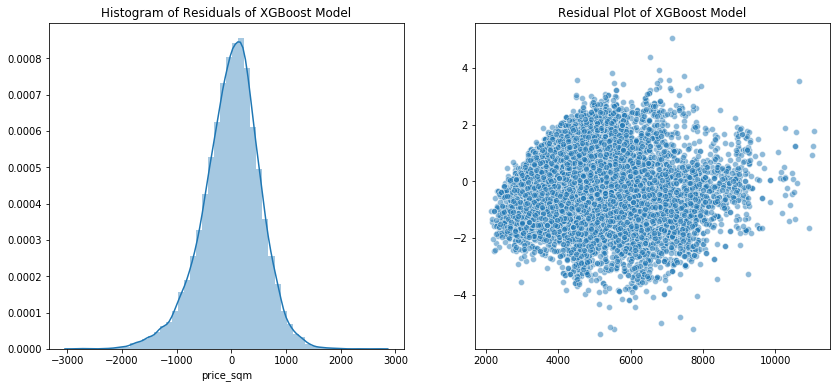

In [307]:
xgb_res = yhat - y_test
xgb_res_sd = statistics.stdev(xgb_res)
xgb_res_st = stats.zscore(xgb_res)

fig2, axes = plt.subplots(1,2, figsize = (14,6))
sns.distplot(xgb_res, ax = axes[0])
sns.scatterplot(y = xgb_res_st, x = yhat, alpha = 0.5, ax = axes[1])
axes[0].set_title("Histogram of Residuals of XGBoost Model", size =12)
axes[1].set_title("Residual Plot of XGBoost Model", size =12);

The residuals of the **XGBoost** model seems to have a normal distribution and is distributed randomly around the horizontal axis in the residuals plot.

Save figure to local drive.

In [308]:
# Save figure in local drive
fig2.savefig("./Images/XGB_Residuals.png")

### 3.6 Model Selection

Both **Lasso Regression** and **XGBoost** model are valid models that showed good predictive abilities on the HDB Flat Resale Price. However, in terms of performance, the **XGBoost** model outperforms the **Lasso Regression** model significantly, with only a mean absolute error of around **2.7%** of the mean of HDB Flat Resale Price (price per sqm). As such, we will be using the **XGBoost** model for the predictive application deployment.

In [197]:
print('Mean absolute error of ' + str(round(statistics.mean(abs(xgb_res))/statistics.mean(y_test)*100,2)) +'% of mean price per sqm')

Mean absolute error of 2.7% of mean price per sqm


Let's have a final look aat our predicted values vs. actual values merged back in the **HDB Flat Resale Data**

In [427]:
# Merge Predicted values to Testing Dataset
df_pred = pd.DataFrame.copy(df_hdb.drop(['price_sqm'], axis = 1))
df_pred = df_pred.merge(y_test, how = 'right', right_index = True, left_index = True)
df_pred['pred_price'] = yhat1
df_pred['pred_resale_price'] = round(df_pred['pred_price']*df_pred['floor_area_sqm'],0)

# Sort columns
cols = df_pred.columns.tolist()
cols = cols[5:6] + cols[-1:] + cols[-3:-1] + cols[0:5] + cols[6:14]
df_pred = df_pred[cols]
df_pred = df_pred.sort_values(by = ['reg_date'], ascending = False)
df_pred.head(10)

,resale_price,pred_resale_price,price_sqm,pred_price,town,flat_type,flat_model,floor_area_sqm,street_name,month,remaining_lease,lease_commence_date,storey_range,id,block,reg_date,year
67654,426000.0,424631.0,4580.645161,4565.923340,PUNGGOL,4 ROOM,Premium Apartment,93.0,PUNGGOL CENTRAL,1.0,89.500000,2010,04 TO 06,67643,301C,2020-01-01,2020
66804,600000.0,597799.0,5084.745763,5066.089844,CLEMENTI,5 ROOM,Improved,118.0,CLEMENTI WEST ST 2,1.0,60.083333,1981,19 TO 21,66801,724,2020-01-01,2020
101798,433888.0,431828.0,3337.600000,3321.753418,WOODLANDS,5 ROOM,Improved,130.0,WOODLANDS ST 31,1.0,71.916667,1993,01 TO 03,101799,301,2020-01-01,2020
67637,375588.0,374900.0,5523.352941,5513.233398,PUNGGOL,3 ROOM,Premium Apartment,68.0,PUNGGOL DRIVE,1.0,95.166667,2016,07 TO 09,67619,667A,2020-01-01,2020
69199,428000.0,435935.0,4652.173913,4738.428223,YISHUN,4 ROOM,Model A,92.0,YISHUN AVE 9,1.0,94.750000,2015,13 TO 15,69215,317A,2020-01-01,2020
101499,710000.0,688264.0,4797.297297,4650.434082,SERANGOON,EXECUTIVE,Maisonette,148.0,SERANGOON NORTH AVE 4,1.0,71.750000,1992,10 TO 12,101497,525,2020-01-01,2020
68152,570000.0,573616.0,5135.135135,5167.714844,SENGKANG,5 ROOM,Premium Apartment,111.0,ANCHORVALE CRES,1.0,94.916667,2015,07 TO 09,68173,335B,2020-01-01,2020
100542,850000.0,849683.0,6910.569106,6907.992676,BUKIT TIMAH,5 ROOM,Standard,123.0,FARRER RD,1.0,53.250000,1974,07 TO 09,100541,5,2020-01-01,2020
100825,465000.0,466943.0,5054.347826,5075.472656,JURONG EAST,4 ROOM,Model A,92.0,TEBAN GDNS RD,1.0,92.666667,2013,31 TO 33,100825,21,2020-01-01,2020
68116,420000.0,420164.0,4565.217391,4566.997559,SENGKANG,4 ROOM,Model A,92.0,FERNVALE RD,1.0,94.500000,2015,07 TO 09,68116,453B,2020-01-01,2020


In [428]:
df_pred.to_csv('./Data/dat_pred.csv', index = False)

## 4. Feature Importance and Interesting Findings

In this section, we will investigate the relationship of some of the important predictors that might be interesting to the target users. We will not attempt to uncover the relationship of each of the top predictors with the target variable, as well as the relationship between each other. I might cover that in a separate notebook perhaps not too long down the road. here we will just highlight general trends.

### 4.1 Top Predictors from XGBoost Model

Let's look at the top 10 most important predictors in the **XGBoost** model.

In [331]:
# Compile feature importance into a dataframe
df_fi = pd.DataFrame(pd.Series(xgb_final.get_fscore()).sort_values(ascending = False)).reset_index()
df_fi['index'] = df_fi['index'].str.extract(r'(\d+)').astype(int)
df_labels = pd.DataFrame(X_test.columns).reset_index()
df_fi = df_fi.merge(df_labels, how = 'left', on = 'index').set_index(['index'])
df_fi.columns = ['F_score', 'Feature Name']
df_fi10 = df_fi[0:10]

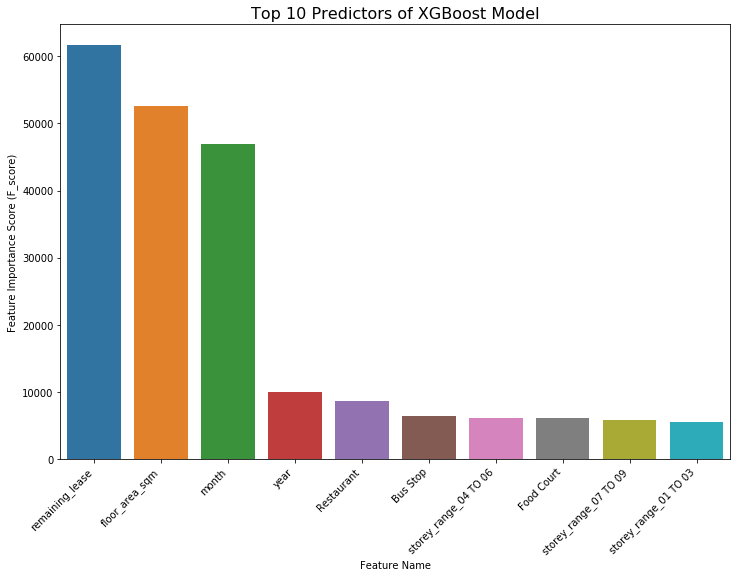

In [332]:
# Plot Feature Importance Plot

plt.figure(figsize = (12,8))
ax5 = sns.barplot(y = df_fi10['F_score'], x=df_fi10['Feature Name'])

ax5.set_title("Top 10 Predictors of XGBoost Model", size = 16)
ax5.set_ylabel('Feature Importance Score (F_score)')

ax5.set_xticklabels(
    ax5.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

*Remaining_lease*, *floor_area_sqm*, and *month* (transaction registration month) are the top three most important features in the **XGBoost** model. The sum of the F scores for the top three features are more than 60% of the total F score for all features. The fourth most important feature is the *year* of the transaction registration date (HDB Flat Resale Application Date), while the number of *Restaurants* within a 500m radius of the property is the fifth most important feature.

In [335]:
df_fi['F_score'][0:3].sum()/df_fi['F_score'].sum()*100

63.50094431498721

### Resale Price (per sqm) Over Remaining Lease

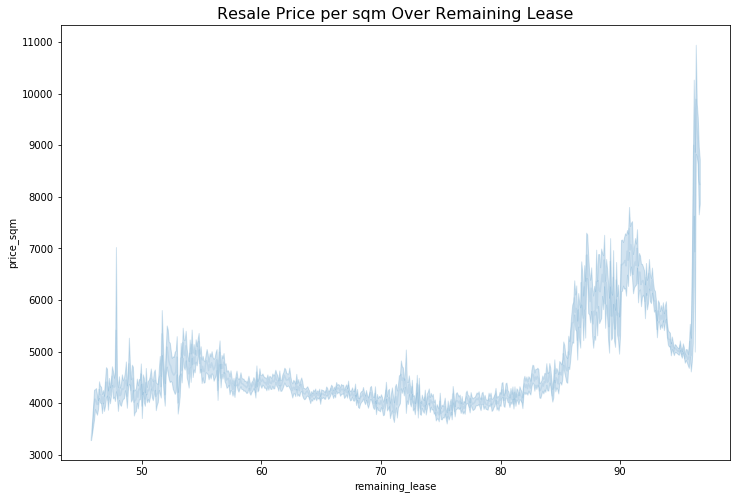

In [348]:
plt.figure(figsize = (12,8))
fig5 = sns.lineplot(x = df_main['remaining_lease'], y = df_main['price_sqm'], alpha = 0.1)
fig5.set_title("Resale Price per sqm Over Remaining Lease", size = 16);

In [349]:
# Save figure in local drive
fig5 = fig5.get_figure()
fig5.savefig("./Images/Resale_Price_Remaining_Lease.png")

### Resale Price (per sqm) Over Floor Area (sqm)

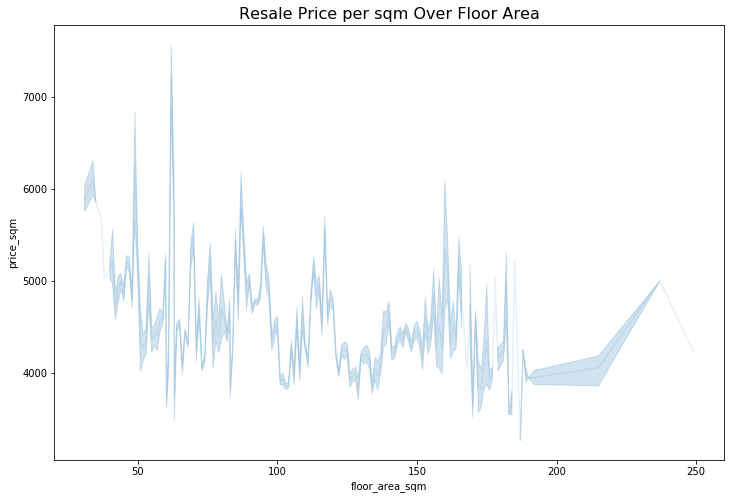

In [350]:
plt.figure(figsize = (12,8))
fig6 = sns.lineplot(x = df_main['floor_area_sqm'], y = df_main['price_sqm'], alpha = 0.1)
fig6.set_title("Resale Price per sqm Over Floor Area", size = 16);

In [351]:
# Save figure in local drive
fig6 = fig6.get_figure()
fig6.savefig("./Images/Resale_Price_Floor_Area.png")

### Resale Price (per sqm) Over HDB Resale Application Date, Year and Month

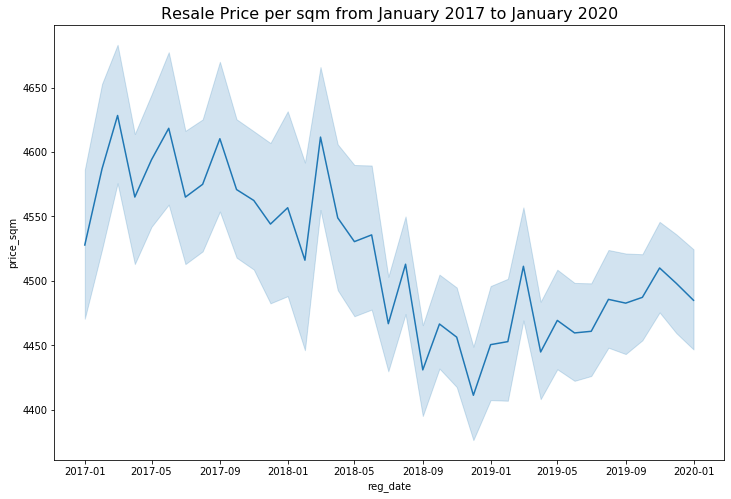

In [339]:
plt.figure(figsize = (12,8))
fig4 = sns.lineplot(x = df_main['reg_date'], y = df_main['price_sqm'])
fig4.set_title("Resale Price per sqm from January 2017 to January 2020", size = 16);

In [340]:
# Save figure in local drive
fig4 = fig4.get_figure()
fig4.savefig("./Images/Resale_Price_Trend.png")

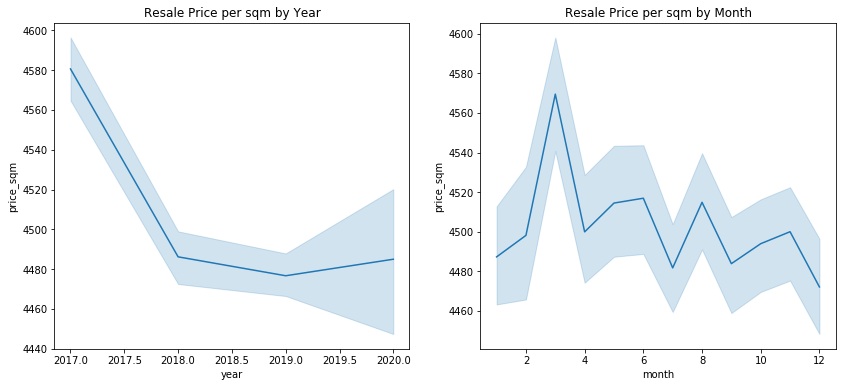

In [342]:
fig3, axes = plt.subplots(1,2, figsize = (14,6))
sns.lineplot(x = df_final['year'], y = df_final['price_sqm'], ax = axes[0])
sns.lineplot(x = df_final['month'], y = df_final['price_sqm'], ax = axes[1])
axes[0].set_title("Resale Price per sqm by Year")
axes[1].set_title("Resale Price per sqm by Month");

In [343]:
# Save figure in local drive
fig3.savefig("./Images/Annual_Monthly_Price_Trend.png")

### Resale Price (per sqm) Over Number of Nearby Restaurants

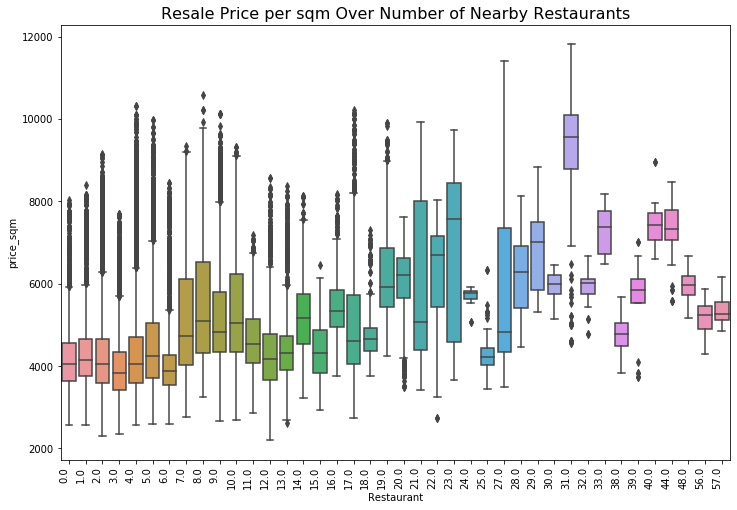

In [359]:
plt.figure(figsize = (12,8))
fig7 = sns.boxplot(x = df_main['Restaurant'], y = df_main['price_sqm'])
fig7.set_title("Resale Price per sqm Over Number of Nearby Restaurants", size = 16)
fig7.set_xticklabels(
    fig7.get_xticklabels(),
    rotation=90,
    horizontalalignment='right');

In [360]:
# Save figure in local drive
fig7 = fig7.get_figure()
fig7.savefig("./Images/Resale_Price_Restaurants.png")

### 4.2 Top Towns with Highest Impact to Resale Price

Even though **Lasso Regression** is not the selected model, it still have good predictive abilities and is useful for us to gain some insights into the relative relationship of a feature to the target variable in an all else equal situation. By looking at the coefficients, we can also deduce its relative importance and impact to the target variable. 

We will look at the values of the coefficients for the different *towns*, and look at the top 10 most premium locations (positive coefficient) and top 10 least desired locations (negative coefficient).

In [378]:
# Merge coefficients with feature name and filter out all non-town variables
df_town = pd.DataFrame()
df_town['Town'] = X_train.columns
df_town['Coef'] = lasso.coef_
df_town = df_town.sort_values(by = ['Coef'], ascending =False)
df_town = df_town.loc[df_town['Town'].str.contains("town"),:].reset_index(drop = True)

In [379]:
# Display Top 10 Expensive Towns
df_town.head(10)

,Town,Coef
0,town_BUKIT MERAH,367.933657
1,town_QUEENSTOWN,332.485091
2,town_KALLANG/WHAMPOA,229.663523
3,town_BISHAN,224.852378
4,town_TOA PAYOH,203.511156
5,town_MARINE PARADE,201.281916
6,town_BEDOK,169.617459
7,town_GEYLANG,168.927703
8,town_CLEMENTI,156.029283
9,town_ANG MO KIO,146.527187


In [387]:
# Display Top 10 Least Expensive Towns
df_town.sort_values(by = "Coef")[0:10]

,Town,Coef
25,town_WOODLANDS,-190.133716
24,town_SENGKANG,-170.330177
23,town_SEMBAWANG,-161.438349
22,town_CHOA CHU KANG,-161.337509
21,town_JURONG WEST,-118.172564
20,town_YISHUN,-104.822364
19,town_PUNGGOL,-91.568452
18,town_BUKIT PANJANG,-82.632655
17,town_BUKIT BATOK,-15.160744
16,town_PASIR RIS,-1.212532


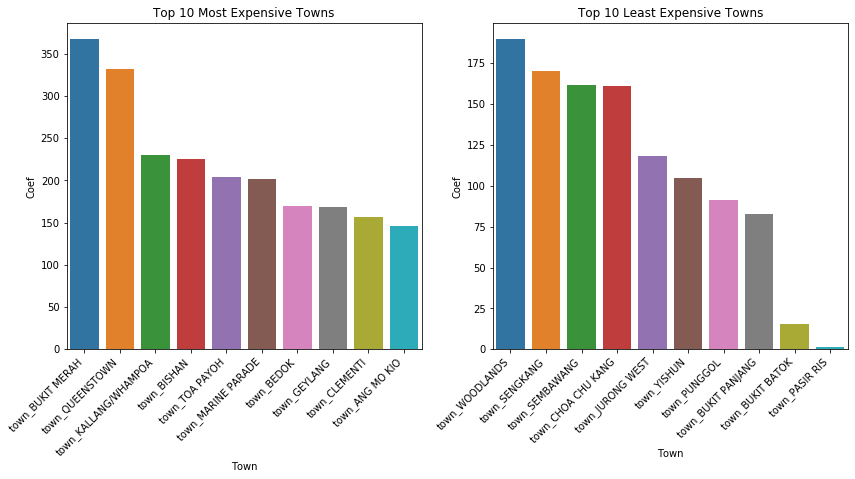

In [389]:
fig8, axes = plt.subplots(1,2, figsize = (14,6))
sns.barplot(x = df_town['Town'][0:10], y = df_town['Coef'], ax = axes[0])
sns.barplot(x = df_town.sort_values(by = "Coef")['Town'][0:10], y = abs(df_town['Coef']), ax = axes[1])
axes[0].set_title("Top 10 Most Expensive Towns")
axes[1].set_title("Top 10 Least Expensive Towns")

axes[0].set_xticklabels(
    axes[0].get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=45,
    horizontalalignment='right');


In [390]:
# Save figure in local drive
fig8.savefig("./Images/Top_Towns.png")